# Simulating **Qiskit Metal** Designs with **palace** and **SQDMetal**

This tutorial explores the simulation of [Qiskit Metal](https://github.com/qiskit-community/qiskit-metal)  `design` objects using `palace`, facilitated by `SQDMetal`. The design of quantum devices, the foundation of the quantum ecosystem, is a multi-step process. Qiskit Metal endeavors to simplify and organize this undertaking.

**About Qiskit Metal**

[Qiskit Metal](https://github.com/qiskit-community/qiskit-metal) 
 \( [docs here](https://qiskit-community.github.io/qiskit-metal/index.html), [tutorials here](https://qiskit-community.github.io/qiskit-metal/tut/index.html)  \)  aims to provide a community-driven platform for quantum chip development, from concept to layout to electromagentics to Hamiltonians and to fabrication, within an open framework. It aims to foster innovation and make the design of quantum devices more accessible.  By automating and building in best practices, testing on real devices, Metal aims to make quantum hardware modeling more straightforward, reduce errors, and improve design speed.  It was started and led by Zlatko Minev, developed with the IBM Qiskit Metal team and many open-source contributors. It employs the permissive Apache 2.0 license and is now a community-maintained open-source package.

 The [Qiskit Metal tutorials](https://qiskit-community.github.io/qiskit-metal/tut/index.html) and [20+ videos on YouTube](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqHl5ZqVmhB_FcSqmLufsjb) offer a good starting point for exploration.

**Contributing to the Future of Device Design**

The continued development of Qiskit Metal relies on its community. If you have an interest in quantum hardware and wish to contribute, consider becoming a maintainer or exploring funding opportunities. We invite you to the **Quantum Metal and device design session**. This will be a discussion with Zlatko Minev, Eli Levinson Falk, and other key figures in the Metal community about its future, the formation of a board of directors, and a maintainer group. If contributing to this effort interests you, we encourage you to connect at this workshop and **join the Thursday workshop on the future of Metal.** 


**What This Tutorial Covers**

Here, we will walk through electrostatic and eigenmode simulations of a qubit-cavity system. We will use `palace`, an open-source finite element analysis tool, through the `SQDMetal` interface. While Qiskit Metal also supports other tools like Elmer, this guide focuses on the `palace` integration.

We will learn to:
1.  Define a qubit-cavity system in Qiskit Metal.
2.  Prepare this design for simulation with `SQDMetal`.
3.  Run electrostatic simulations in `palace` to examine charge distributions and capacitances.
4.  Conduct eigenmode simulations in `palace` to find resonant frequencies and mode profiles.

This tutorial aims to provide a working knowledge of how these open-source tools can be combined for the analysis of superconducting quantum circuits, helping to reveal the underlying physics at play.

**Requirements:**

* [ ] Ensure that [`SQDMetal`](https://github.com/sqdlab/SQDMetal) is installed in your environment. This package includes installation of Qiskit Metal.
* [ ] Ensure that [`palace`](https://github.com/sqdlab/palace) is installed in your environment. Instructions are [here](https://lfl-lab.github.io/SQuADDS/source/resources/palace.html).

Let us begin the exploration.

# Transmon + Resonator System

This module models the transmon qubit in the cooper-pair charge basis, assuming wrapped junction phase variable. The Hamiltonian is given by: 

$$
\hat{H}=4E_{C}\left(\hat{n}-n_{g}\right)-E_{J}\cos\left(\hat{\phi}\right)\,,
$$

where $E_{C}$ is the charging energy, $E_{J}$ is the Josephson energy, $\hat n$ is the number of Cooper pairs transferred between charge islands, $\hat{\phi}$ is the gauge-invariant phase difference between charge islands, and $n_{g}$ is effective offset charge of the device. Expressions for the charging energy, Josephson energy and offset charge can be written as:

$$
E_{C}=\frac{e^{2}}{2C_{\Sigma}}\,,\qquad n_{g}=-\frac{C_{d}\dot{\Phi}_{s}\left(t\right)}{2e}\:,\qquad E_{J}=\frac{\phi_{0}^{2}}{L_{J}}\,,
$$

where $C_{\Sigma} = C_{J}+C_{B}+C_{g}$ (the sum of the Josephson capacitance, shunting capacitance and gate capacitance), $L_{J}$ is the inductance of the Josephson junction, and $\phi$ is the magnetic flux. 

The variables are
$$
\hat{\phi}\equiv\frac{\hat{\Phi}}{\phi_{0}},\qquad\hat{n}\equiv\frac{\hat{Q}}{2e}\,,
$$

Observe that $\hat \phi$ and $\hat n$ are both dimensiuonless, and they obey the commutation relationship:

$$
[\hat{\phi}, \hat{n}] = i
$$


The Hamiltonian can be written in the charge ($\hat n$) basis as: 

$$H=4E_\text{C}(\hat{n}-n_g)^2-\frac{1}{2}E_\text{J}\sum_n(|n\rangle\langle n+1|+\text{h.c.}),$$
Where $\hat{n} = \sum_{n=-\inf}^{\inf} |n\rangle\langle n|$

### Hcpb class

Hamiltonian-model Cooper pair box (Hcpb) class.

Used to model analytically the CPB Hamiltonian quickly
and efficiently. Solves in charge basis tridiagonal eigenvalue
problem for arbitrary Ej, Ec, ng values.

As long as nlevels remains fixed the number of charge states
considered does not change and it does not recreate the arrays,
just recomputes the properties

Returns all properties of interest for the CPB.

This model is closer to the analytic solution than the Duffing oscillator model.
Can work backwards from target qubit parameters to get the Ej, Ec or use
input Ej, Ec to find the spectrum of the Cooper Pair Box.

In [14]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True
%matplotlib inline
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

from qiskit_metal.analyses.hamiltonian.transmon_charge_basis import Hcpb
from qiskit_metal.analyses.hamiltonian.transmon_CPB_analytic import Hcpb_analytic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We can get a feel for how to use the Hcpb class by plotting the first few eigenvalues as a function of offset charge, similar to the plots reported in Phys. Rev. A 76, 042319 (2007.) Let's start by defining the range of offset charge from -2.0 to +2.0 and also by defining a normalization for the eigenvalues, which will be the transition energy between the first two states evaluated at the degenercy point where ng=0.5. For this exercise, we'll take Josephson Energy to be equal to the charging energy:

In [15]:
x = np.linspace(-2.0,2.0,101) # this represents the charging energy (ng)
H_norm = Hcpb(nlevels=2, Ej=1000.0, Ec=1000.0, ng=0.5) # Hamiltonian definition 
norm = H_norm.fij(0,1) # normalization constant 

Next, we'll sweep over the offset charge and calculate the first three eigenvalues for a given value of ng. We'll need to define a new Hamiltonian for this. 

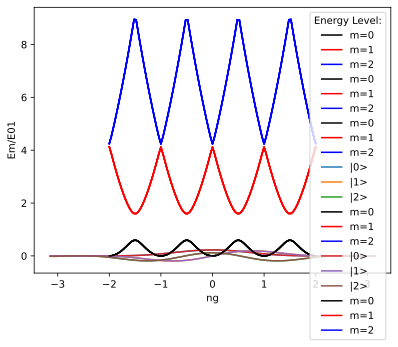

In [16]:
E0, E1, E2 = [], [], []

# For a given value of offset charge (ng, represented by x) we will calculate the CPB Hamiltonian using the previously assigned values of E_J and E_C. Then we calculate the eigenvalue for a given value of m.
for i in x: 
    H = Hcpb(nlevels=3, Ej=1000.0, Ec=1000.0, ng=i)
    E0.append(H.evalue_k(0)/norm)
    E1.append(H.evalue_k(1)/norm)
    E2.append(H.evalue_k(2)/norm)

# define the minimum of E0 and set this to E=0
floor = min(E0) 
 
plt.plot(x, E0 - floor, 'k', label="m=0")
plt.plot(x, E1 - floor, 'r', label="m=1")
plt.plot(x, E2 - floor, 'b', label="m=2")
plt.xlabel("ng")
plt.ylabel("Em/E01")
plt.legend(title="Energy Level:", loc='upper right')
plt.show()

# Wavefunction

Let's define a new Hamiltonian, this time with $E_{J} >> E_{C}$ and an offset charge of $ng=0.001$. We can calculate the transition energy between the lowest two states as well as the anharmonicity with the following: 

In [17]:
H = Hcpb(nlevels=3, Ej=13971.3, Ec=295.2, ng=0.001)
print(f"""
Transmon frequencies 

 ω01/2π = {H.fij(0,1): 6.0f} MHz
   α/2π = {H.anharm(): 6.0f} MHz
""")



Transmon frequencies 

 ω01/2π =   5604 MHz
   α/2π =     11 MHz



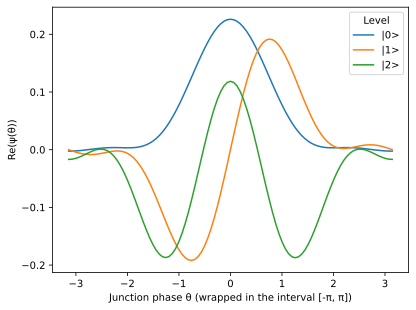

In [18]:
import matplotlib.pyplot as plt
for k in range (3):
    ψ, θ = H.psi_k(k,101)
    plt.plot(θ, ψ.real+ψ.imag, label=f"|{k}>") # it's in either quadrature, but not both
plt.xlabel("Junction phase θ (wrapped in the interval [-π, π])")
plt.ylabel("Re(ψ(θ))")
plt.legend(title="Level")
plt.show()

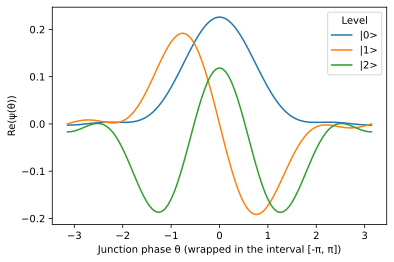

In [ ]:
import matplotlib.pyplot as plt
for k in range (3):
    ψ, θ = H.psi_k(k,101)
    plt.plot(θ, ψ.real+ψ.imag, label=f"|{k}>") # it's in either quadrature, but not both
plt.xlabel("Junction phase θ (wrapped in the interval [-π, π])")
plt.ylabel("Re(ψ(θ))")
plt.legend(title="Level")

### Verifying Orthonormality of the Wavefunctions

Here, we can verify the orthonormality of the wavefunctions. Let's first take the first two eigenstates and verify that their inner product is zero, thereby confirming orthogonality. Note that since the wavefunctions can be complex, we need to take the complex conjugate of $\Psi1$. 

In [ ]:
Psi0, theta0 = H.psi_k(0)
Psi1, theta1 = H.psi_k(1)
print(np.dot(Psi0,Psi1.conj()))

(-2.2354805733859444e-09-3.4875983780408155e-17j)


Indeed, we see that the dot product is essentially zero (within numerical precision.) Next, let's take the inner product of the first eigenstate with itself, checking that we get an output of unity:

In [ ]:
print(np.dot(Psi0, Psi0.conj()))
print(np.dot(Psi1, Psi1.conj()))

(1+0j)
(1+0j)


Indeed we see that the dot products are essentially equal to unity, confirming that the states are appropriately normalized.  

# Additional Analysis: Charge Dispersion, Energy Level Differences, Anharmonicity and Dephasing Time (T2)

### Charge Dispersion

The peak-to-peak value of the charge dispersion for the mth energy level is given by the expression: $\epsilon_{m} = E_{m}(n_{g}=0.5) - E_{m}(n_{g}=0.0)$. We can plot $\epsilon_{m}/E_{01}$ as a function of $E_{J}/E_{C}$ for the first few energy levels and reproduce the figure published in Phys. Rev. A 76, 042319 (2007) (Figure 4(a)). 

We can start by defining a value of charging energy and creating empty lists for $\epsilon_{0}$ through $\epsilon_{4}$: 

In [ ]:
E_c=100.0 # charging energy 
epsilon0, epsilon1, epsilon2, epsilon3 = [], [], [], []    # charge dispersion for m=0 through m=4
x = np.linspace(1,140,101)           # this this ratio of Ej/Ec which will go on the x-axis. 

Next, we simply evaluate the expression given above for $\epsilon_{m}$ based on $E_{m}$ and $E_{0}$. We use two separate Hamiltonians to do this; one evaluated at $n_{g}=0.5$ and one evaluated at $n_{g}=0.0$. We also normalize by the transition energy between the lowest two states evaluated at the degeneracy point ($E_{01}$.) Finally, we populate the lists each $\epsilon_{m}$. 

In [ ]:
for i in x:
    E_j = i*E_c 
    H_zero = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.0)
    H_half = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    
    H_norm = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    norm = H_norm.fij(0,1)                         # normalization constant 
    
    epsilon0.append(abs(H_half.evalue_k(0) - H_zero.evalue_k(0))/norm)
    epsilon1.append(abs(H_half.evalue_k(1) - H_zero.evalue_k(1))/norm)
    epsilon2.append(abs(H_half.evalue_k(2) - H_zero.evalue_k(2))/norm)
    epsilon3.append(abs(H_half.evalue_k(3) - H_zero.evalue_k(3))/norm)

We can plot these values to see the exponential decrease in the charge dispersion with increasing $E_{J}/E_{C}$: 

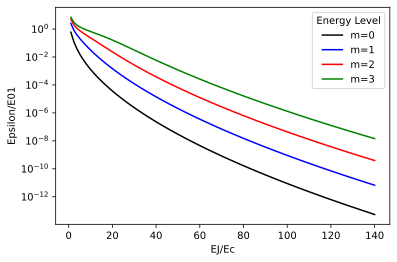

In [ ]:
plt.plot(x, epsilon0, 'k', label="m=0")
plt.plot(x, epsilon1, 'b', label="m=1")
plt.plot(x, epsilon2, 'r', label="m=2")
plt.plot(x, epsilon3, 'g', label="m=3") 
plt.yscale("log")
plt.xlabel("EJ/Ec")
plt.ylabel("Epsilon/E01")
plt.legend(title="Energy Level", loc='upper right')

In [19]:
import scqubits as scq

In [20]:
qubit = scq.Transmon(
    EJ=13.97124102543,
    EC=0.295179,
    ng=0.001,
    ncut=40,
    truncated_dim=4     # after diagonalization, we will keep 3 levels
)
evals = qubit.eigenvals(evals_count=12)
print(f"freq = {(evals[1] - evals[0])* 1000:.0f} MHz")
print(f"alpha = {((evals[2] - evals[1]) - (evals[1] - evals[0]))* 1000:.0f} MHz")

freq = 5431 MHz
alpha = -341 MHz


array([[1889.24005846,   -6.98562051,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  -6.98562051, 1795.96113303,   -6.98562051, ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,   -6.98562051, 1705.0436396 , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 1704.86417076,
          -6.98562051,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,   -6.98562051,
        1795.77694133,   -6.98562051],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
          -6.98562051, 1889.0511439 ]])

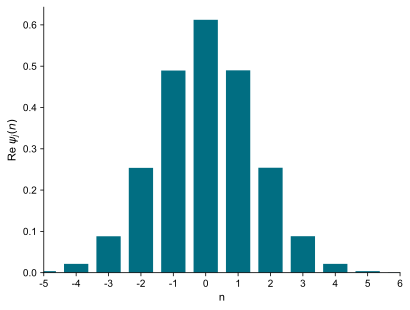

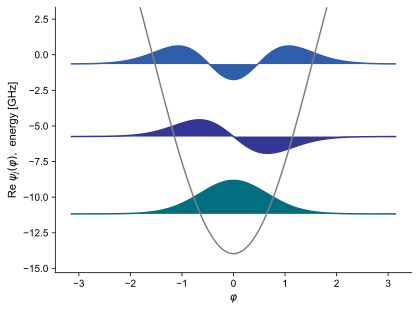

In [21]:
qubit.plot_n_wavefunction()
qubit.plot_phi_wavefunction(which=[0,1,2], mode='real')
qubit.hamiltonian()

Spectral data:   0%|          | 0/220 [00:00<?, ?it/s]

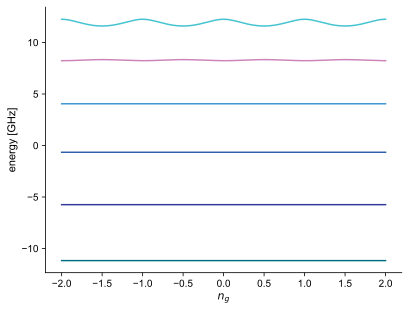

In [22]:
import numpy as np
ng_list = np.linspace(-2, 2, 220)
qubit.plot_evals_vs_paramvals('ng', ng_list, evals_count=6, subtract_ground=False);